HSE, Applied Time Series Forecasitng , Winter 2022-23 

<font color="blue"> Lesson #7: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)
from datetime import datetime

In [ ]:
custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")

# загружаем данные
ts_retail = pd.read_csv('train_kaggle/train_kaggle.csv', parse_dates=['Date'], date_parser=custom_date_parser)
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail.head()

Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price
Date                                                                   
2015-01-01         1       1    NaN      22         163.78          NaN
2015-01-02         1       1    NaN      41         163.78          NaN
2015-01-03         1       1    NaN      35         163.78          NaN
2015-01-04         1       1    NaN      72         163.78          NaN
2015-01-05         1       1    NaN      25         163.78          NaN

In [ ]:
ts_retail.tail()

Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price
Date                                                                   
2016-05-18       106       2    NaN       9          138.5          NaN
2016-05-19       106       2    NaN       3          138.5          NaN
2016-05-20       106       2    NaN      13          138.5          NaN
2016-05-21       106       2    NaN       3          138.5          NaN
2016-05-22       106       2    NaN       0          138.5          NaN

In [ ]:
skus = ts_retail['SKU_id'].unique()
print(sorted(skus))

stores = ts_retail['Store_id'].unique()
print(sorted(stores))

[1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 104, 105, 106]


In [ ]:
ts_retail_test = pd.read_csv('test_kaggle.csv', parse_dates=['Date'], date_parser=custom_date_parser)
ts_retail_test['Date'] = pd.to_datetime(ts_retail_test['Date'], dayfirst = True)
ts_retail_test.set_index(['Date'], inplace=True)

skus = ts_retail_test['SKU_id'].unique()
print(sorted(skus))

stores = ts_retail_test['Store_id'].unique()
print(sorted(stores))

[1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]


In [ ]:
ts_retail_test.head()

id  Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price
Date                                                                       
2016-05-23   0         1       1    1.0     NaN         128.98        119.6
2016-05-24   1         1       1    NaN     NaN         128.98          NaN
2016-05-25   2         1       1    NaN     NaN         131.70          NaN
2016-05-26   3         1       1    NaN     NaN         131.70          NaN
2016-05-27   4         1       1    NaN     NaN         131.70          NaN

In [ ]:
test_start_dt = '05-22-2016'
test_end_dt = '06-19-2016'

ts_retail = ts_retail.append(ts_retail_test)
ts_retail = ts_retail.loc[:test_end_dt]
ts_retail.head()

Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price  id
Date                                                                       
2015-01-01         1       1    NaN    22.0         163.78          NaN NaN
2015-01-02         1       1    NaN    41.0         163.78          NaN NaN
2015-01-03         1       1    NaN    35.0         163.78          NaN NaN
2015-01-04         1       1    NaN    72.0         163.78          NaN NaN
2015-01-05         1       1    NaN    25.0         163.78          NaN NaN

In [ ]:
ts_retail.tail()

Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price  \
Date                                                                      
2016-06-15       110       2    NaN     NaN         133.06          NaN   
2016-06-16       110       2    NaN     NaN         133.06          NaN   
2016-06-17       110       2    NaN     NaN         133.06          NaN   
2016-06-18       110       2    NaN     NaN         133.06          NaN   
2016-06-19       110       2    NaN     NaN         133.06          NaN   

                id  
Date                
2016-06-15  5965.0  
2016-06-16  5966.0  
2016-06-17  5967.0  
2016-06-18  5968.0  
2016-06-19  5969.0

At this point we have attached the test time series to train. We will split them later by start date "2016-05-22." Let's keep them together for now to optimize data processing.

<AxesSubplot: xlabel='Date'>

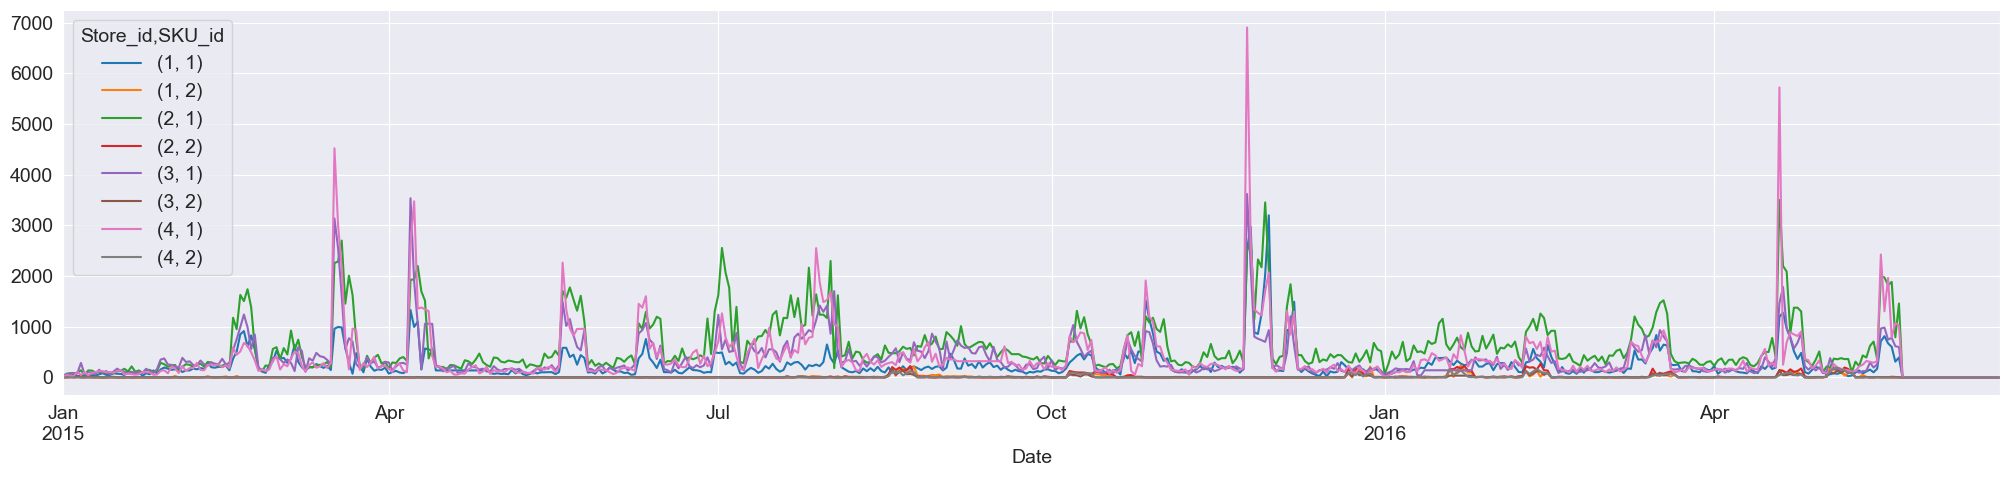

In [ ]:
# Draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method).\
     unstack(groupby_columns)[target_column]
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot()
  return fig


plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 8)

<AxesSubplot: xlabel='Date'>

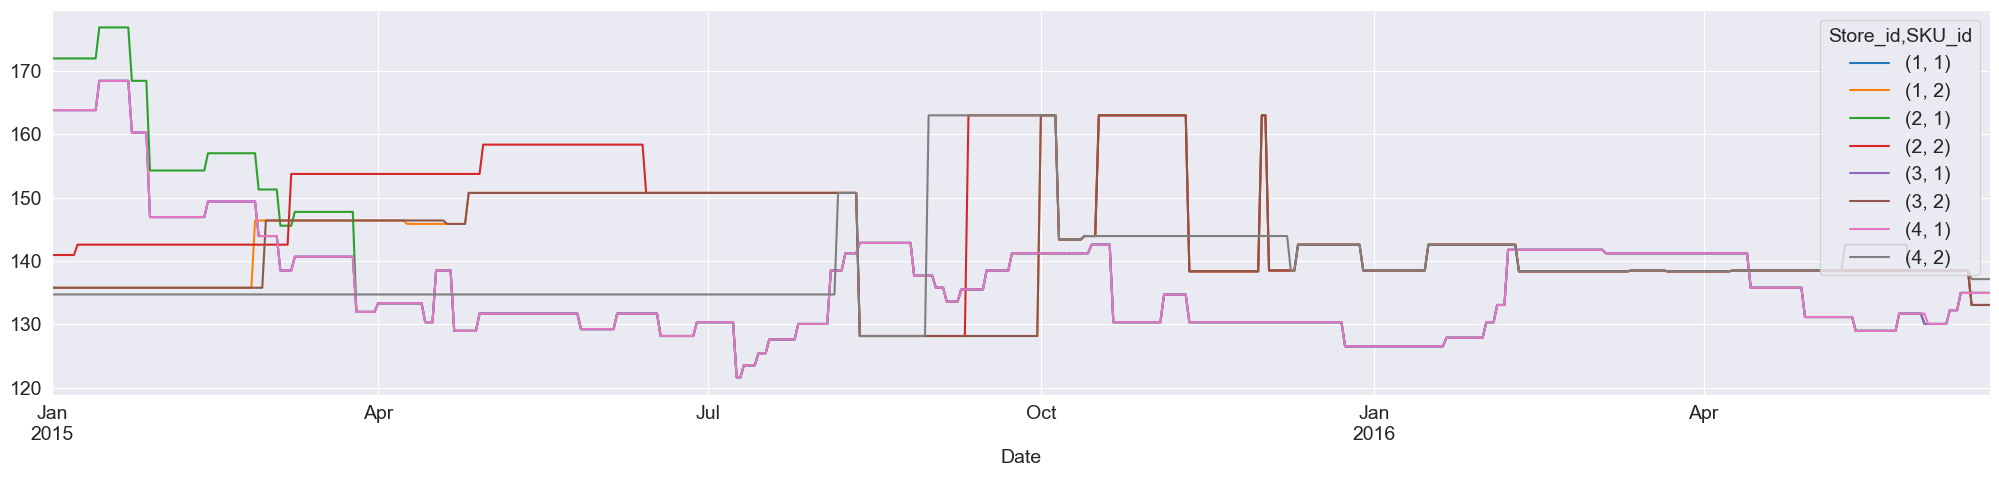

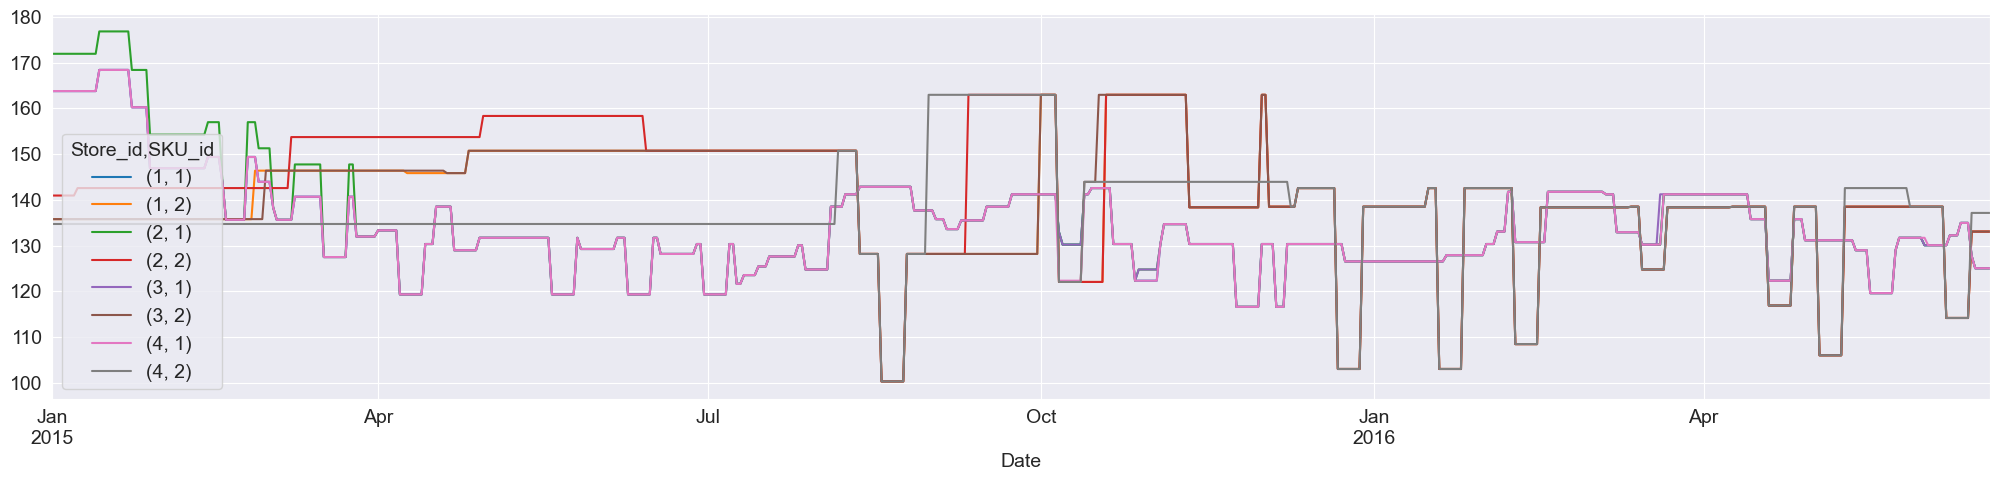

In [ ]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Regular_Price', ts_num = 8)

# Add actual price (promo price when promo occurred or regular price otherwise)
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price)
ts_retail['Discount'] = ts_retail.apply(lambda row: ((row.Regular_Price - row.Promo_Price) / row.Promo_Price) * 100, axis=1)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Actual_Price', ts_num = 8)

<AxesSubplot: xlabel='Date'>

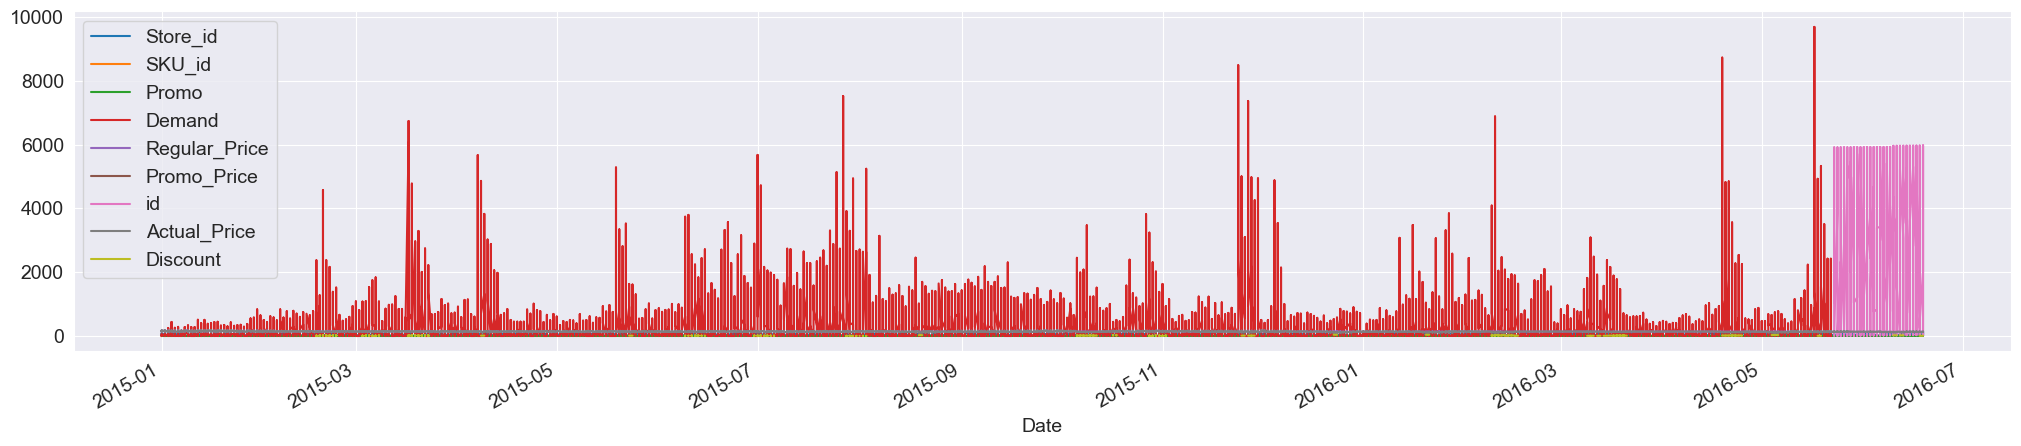

<Figure size 2500x500 with 0 Axes>

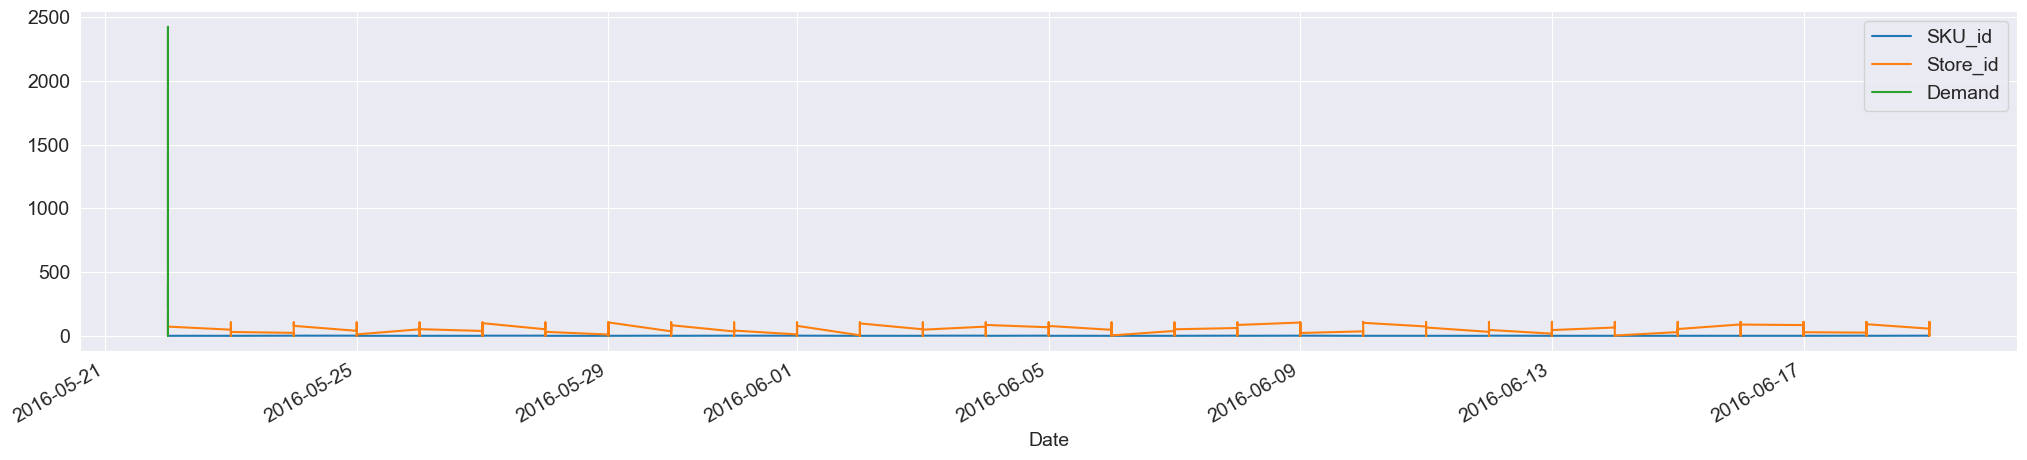

In [ ]:
# prepare test/train datasets
train = ts_retail.copy(deep=True)
train.plot()
test_y = ts_retail.loc[test_start_dt:, ['SKU_id','Store_id','Demand']]

plt.figure()
test_y.plot()

<AxesSubplot: xlabel='Date'>

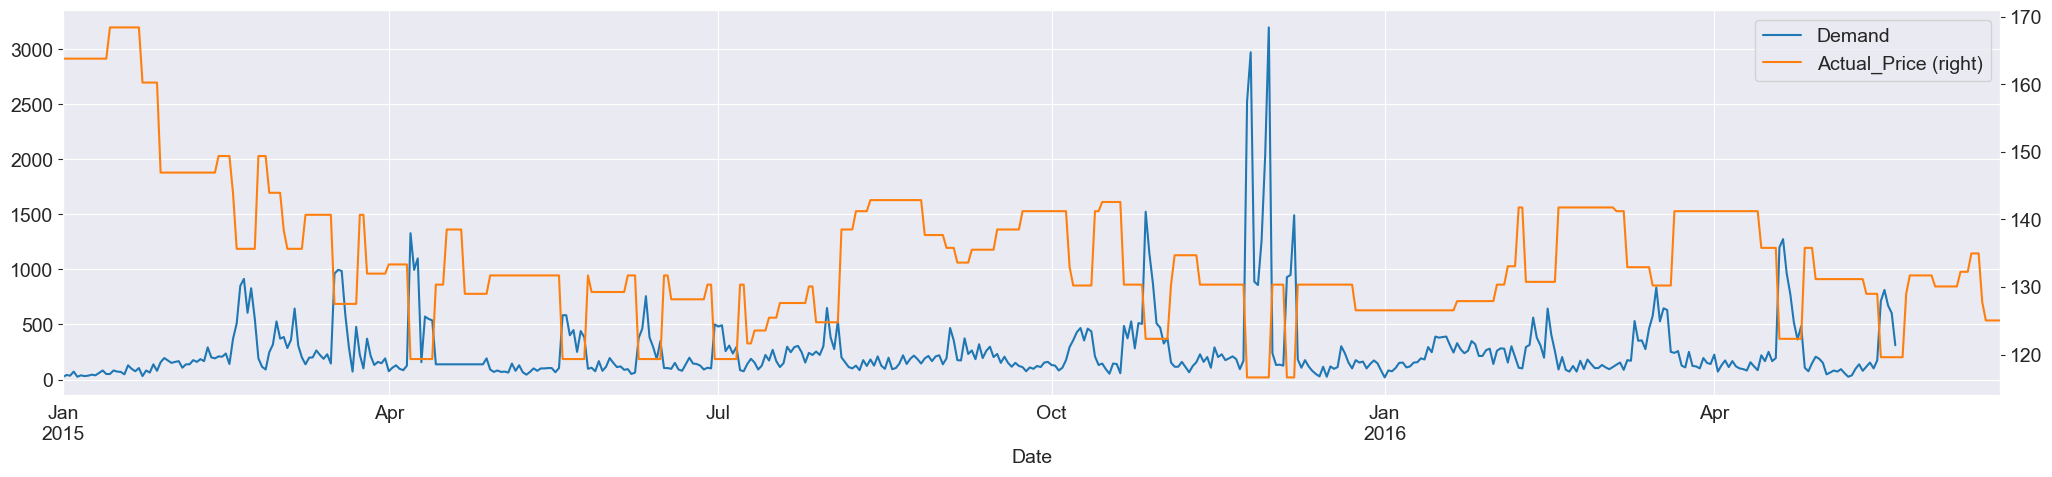

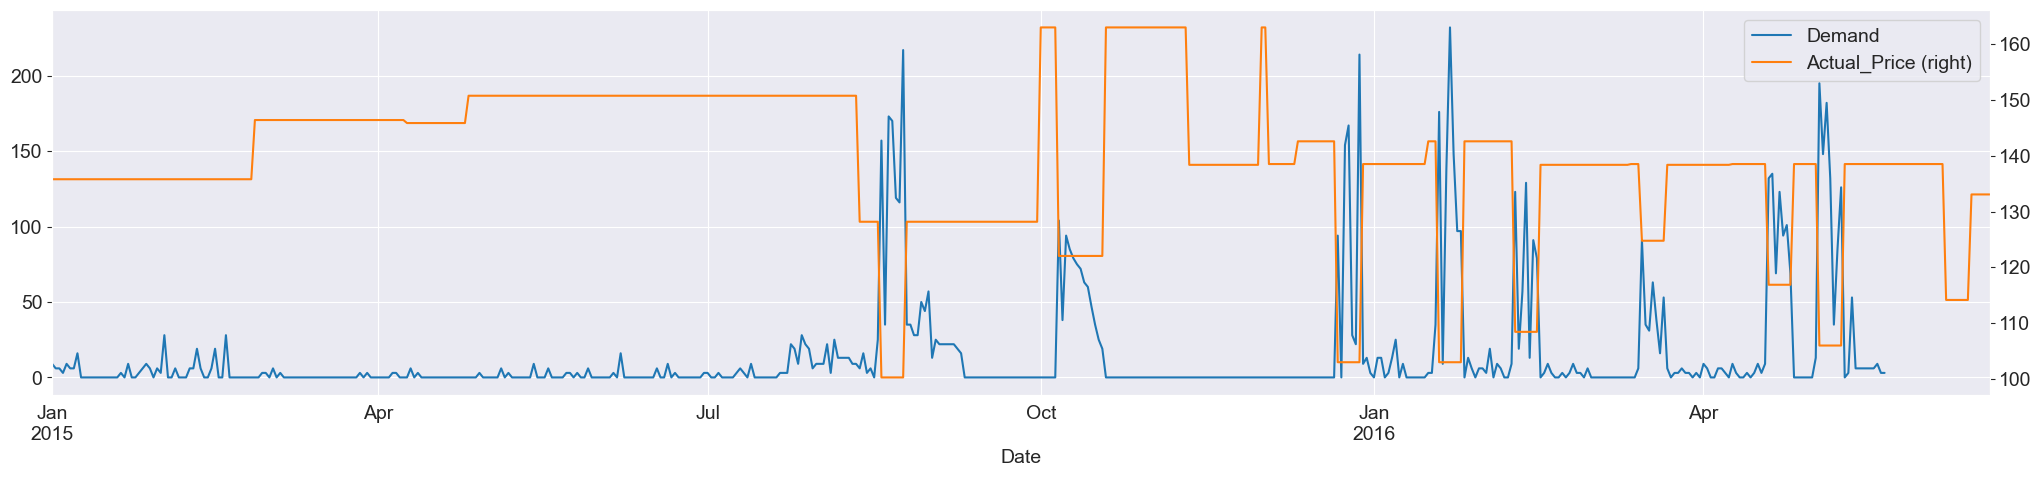

In [ ]:
# Aggregate on Sku - All Stores level
sales_by_sku_store = train.reset_index().set_index('Date')
sales_by_sku_store.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

#sales_by_sku_store = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date').rename(columns = {'Store_id':'Store_count'})
#sales_by_sku_store.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

store_1 = sales_by_sku_store[sales_by_sku_store['Store_id'] == 1]
store_1[store_1['SKU_id'] == 1][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])
store_1[store_1['SKU_id'] == 2][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [ ]:
sales_by_sku_store
sales_by_sku_store = sales_by_sku_store.drop('id', axis=1)
sales_by_sku_store = sales_by_sku_store.drop('Promo_Price', axis=1)
sales_by_sku_store = sales_by_sku_store.drop('Regular_Price', axis=1)
sales_by_sku_store['Discount'] = sales_by_sku_store['Discount'].replace(np.nan, 0)
sales_by_sku_store.head()

Store_id  SKU_id  Promo  Demand  Actual_Price  Discount
Date                                                               
2015-01-01         1       1    0.0    22.0        163.78       0.0
2015-01-02         1       1    0.0    41.0        163.78       0.0
2015-01-03         1       1    0.0    35.0        163.78       0.0
2015-01-04         1       1    0.0    72.0        163.78       0.0
2015-01-05         1       1    0.0    25.0        163.78       0.0

# ML for time series Forecasting

In [ ]:
import holidays

# feature generation
data = sales_by_sku_store.reset_index().copy(deep = True)

data["month"] = data.Date.dt.month
data["weekday"] = data.Date.dt.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# one hot for month
transformed = ohe.fit_transform(data[['month']])
data[ohe.categories_[0]] = transformed.toarray()
data = data.drop('month', axis=1)

data.head()

Date  Store_id  SKU_id  Promo  Demand  Actual_Price  Discount  \
0 2015-01-01         1       1    0.0    22.0        163.78       0.0   
1 2015-01-02         1       1    0.0    41.0        163.78       0.0   
2 2015-01-03         1       1    0.0    35.0        163.78       0.0   
3 2015-01-04         1       1    0.0    72.0        163.78       0.0   
4 2015-01-05         1       1    0.0    25.0        163.78       0.0   

   weekday  is_weekend    1  ...    3    4    5    6    7    8    9   10   11  \
0        3           0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        4           0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        5           1  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        6           1  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0           0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    12  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 21 columns]

In [ ]:
data.tail()

Date  Store_id  SKU_id  Promo  Demand  Actual_Price  Discount  \
92881 2016-06-15       110       2    0.0     NaN        133.06       0.0   
92882 2016-06-16       110       2    0.0     NaN        133.06       0.0   
92883 2016-06-17       110       2    0.0     NaN        133.06       0.0   
92884 2016-06-18       110       2    0.0     NaN        133.06       0.0   
92885 2016-06-19       110       2    0.0     NaN        133.06       0.0   

       weekday  is_weekend    1  ...    3    4    5    6    7    8    9   10  \
92881        2           0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
92882        3           0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
92883        4           0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
92884        5           1  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
92885        6           1  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

        11   12  
92881  0.0  0.0  
92882  0.0  0.0  
92883  0.0  0.0  
92884  0.0  0.0  
92885  0.0  0.0  

[5 rows x 21 columns]

### Lagged Features Generation

In [ ]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
              
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            

    return out_df

In [ ]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_
    
# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:
    
    ''' 
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                
                ## add rolling features
                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

In [ ]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'

data_lagged_features = generate_lagged_features(data 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [7, 14, 21, 28]
                    , windows = ['7D', '14D', '21D', '28D']
                    , preagg_methods = ['sum']
                    , agg_methods = [pd.Series.kurtosis, pd.Series.skew]
                    , dynamic_filters = ['Promo', 'weekday']
                    , ewm_params={'weekday': [7, 14, 21, 28], 'Promo': [7, 14, 21, 28]}
                    )

IntProgress(value=0, max=64)

In [ ]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

117


Index([                                                                'Date',
                                                                   'Store_id',
                                                                     'SKU_id',
                                                                      'Promo',
                                                                     'Demand',
                                                               'Actual_Price',
                                                                   'Discount',
                                                                    'weekday',
                                                                 'is_weekend',
                                                                            1,
       ...
               'Demand_lag28d_alpha21_keySKU_id_preagsum_weekday_dynamic_ewm',
               'Demand_lag28d_alpha28_keySKU_id_preagsum_weekday_dynamic_ewm',
        'Demand_lag28d_w7D_keySKU_id_prea

In [ ]:
data_lagged_features = data_lagged_features.reset_index().set_index('Date')
data_lagged_features.head()


index  Store_id  SKU_id  Promo  Demand  Actual_Price  Discount  \
Date                                                                         
2015-01-01      0         1       1    0.0    22.0        163.78       0.0   
2015-01-01      1        19       1    0.0    25.0        163.78       0.0   
2015-01-01      2        39       2    0.0     3.0        135.78       0.0   
2015-01-01      3        40       2    0.0     0.0        135.78       0.0   
2015-01-01      4        18       1    0.0    13.0        163.78       0.0   

            weekday  is_weekend    1  ...  \
Date                                  ...   
2015-01-01        3           0  1.0  ...   
2015-01-01        3           0  1.0  ...   
2015-01-01        3           0  1.0  ...   
2015-01-01        3           0  1.0  ...   
2015-01-01        3           0  1.0  ...   

            Demand_lag28d_alpha21_keySKU_id_preagsum_weekday_dynamic_ewm  \
Date                                                                       
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              

            Demand_lag28d_alpha28_keySKU_id_preagsum_weekday_dynamic_ewm  \
Date                                                                       
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              
2015-01-01                                                NaN              

            Demand_lag28d_w7D_keySKU_id_preagsum_agkurt_weekday_dynamic_rolling  \
Date                                                                              
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     

            Demand_lag28d_w7D_keySKU_id_preagsum_agskew_weekday_dynamic_rolling  \
Date                                                                              
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     
2015-01-01                                                NaN                     

            Demand_lag28d_w14D_keySKU_id_preagsum_agkurt_weekday_dynamic_rolling  \
Date                                                                               
2015-01-01                                                NaN                      
2015-01-01                                                NaN                      
2015-01-01                                                NaN                      
2015-01-01                                                NaN                      
2015-01-01                                                NaN                      

            Demand_lag28d_w14D_keySKU_id_preagsum_agskew_weekday_dynamic_rolling  \
Date                                                                               
2015-01-01                                                NaN                      
2015-01-01                                                NaN                 

## ML model definition

In [ ]:
data_lagged_features = data_lagged_features.drop('index', axis=1)
data_lagged_features = data_lagged_features.drop('weekday', axis=1)
data_lagged_features.tail()

Store_id  SKU_id  Promo  Demand  Actual_Price  Discount  \
Date                                                                  
2016-06-19        47       1    1.0     NaN        125.04  7.933461   
2016-06-19        47       2    0.0     NaN        139.86  0.000000   
2016-06-19        48       2    0.0     NaN        137.14  0.000000   
2016-06-19        45       2    0.0     NaN        139.86  0.000000   
2016-06-19       110       2    0.0     NaN        133.06  0.000000   

            is_weekend    1    2    3  ...  \
Date                                   ...   
2016-06-19           1  0.0  0.0  0.0  ...   
2016-06-19           1  0.0  0.0  0.0  ...   
2016-06-19           1  0.0  0.0  0.0  ...   
2016-06-19           1  0.0  0.0  0.0  ...   
2016-06-19           1  0.0  0.0  0.0  ...   

            Demand_lag28d_alpha21_keySKU_id_preagsum_weekday_dynamic_ewm  \
Date                                                                       
2016-06-19                                       12796.861777              
2016-06-19                                        1760.999750              
2016-06-19                                        1760.999750              
2016-06-19                                        1760.999750              
2016-06-19                                        1760.999750              

            Demand_lag28d_alpha28_keySKU_id_preagsum_weekday_dynamic_ewm  \
Date                                                                       
2016-06-19                                       15206.014402              
2016-06-19                                        2108.972295              
2016-06-19                                        2108.972295              
2016-06-19                                        2108.972295              
2016-06-19                                        2108.972295              

            Demand_lag28d_w7D_keySKU_id_preagsum_agkurt_weekday_dynamic_rolling  \
Date                                                                              
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     

            Demand_lag28d_w7D_keySKU_id_preagsum_agskew_weekday_dynamic_rolling  \
Date                                                                              
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     
2016-06-19                                                NaN                     

            Demand_lag28d_w14D_keySKU_id_preagsum_agkurt_weekday_dynamic_rolling  \
Date                                                                               
2016-06-19                                                NaN                      
2016-06-19                                                NaN                      
2016-06-19                                                NaN                      
2016-06-19                                                NaN                      
2016-06-19                                                NaN                      

            Demand_lag28d_w14D_keySKU_id_preagsum_agskew_weekday_dynamic_rolling  \
Date                                                                               
2016-06-19                                                NaN                      
2016-06-19                                                NaN                      
2016-06-19                          

In [ ]:
stores = data_lagged_features['Store_id'].unique()
skus = data_lagged_features['SKU_id'].unique()

train_sets = {}

for store_id in stores:
    for sku_id in skus:
        filtered_by_store = data_lagged_features[data_lagged_features['Store_id'] == store_id]
        filtered_by_sku_and_store = filtered_by_store[filtered_by_store['SKU_id'] == sku_id]
        
        train_sets['{store}_{sku}'.format(store = store_id, sku = sku_id)] = filtered_by_sku_and_store

## ML Model Training

In [ ]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

lgbms = {}
keys_to_remove = []

parameters = {
    'metric' : ['mae'],
    'n_estimators': [ 100, 200, 500 ],
    'learning_rate':[ 0.1, 0.05, 0.005 ],
    'feature_fraction': [ 0.6, 0.8, 0.9],
    'num_leaves':[ 20, 40, 60 ]
}

for key, value in train_sets.items():
    try:

        if value.empty:
            keys_to_remove.append(key)
            continue
        
        lgbm = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.01,
                        feature_fraction=0.6,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
        
        lgbm.fit(X = value.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1), y = value.loc[:test_start_dt].Demand)
        
        if key not in lgbms:
            lgbms[key] = lgbm
        #g_lgbm = GridSearchCV(lgbm, param_grid = parameters, n_jobs = 6, verbose = 10)
        #g_lgbm.fit(value.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1), value.loc[:test_start_dt].Demand)
            
        
        #lgbms[key] = g_lgbm
    except Exception:
        keys_to_remove.append(key)
        
for key in keys_to_remove:
    print(key + " will use a global LGBM")
    train_sets.pop(key, None)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 

: 

: 

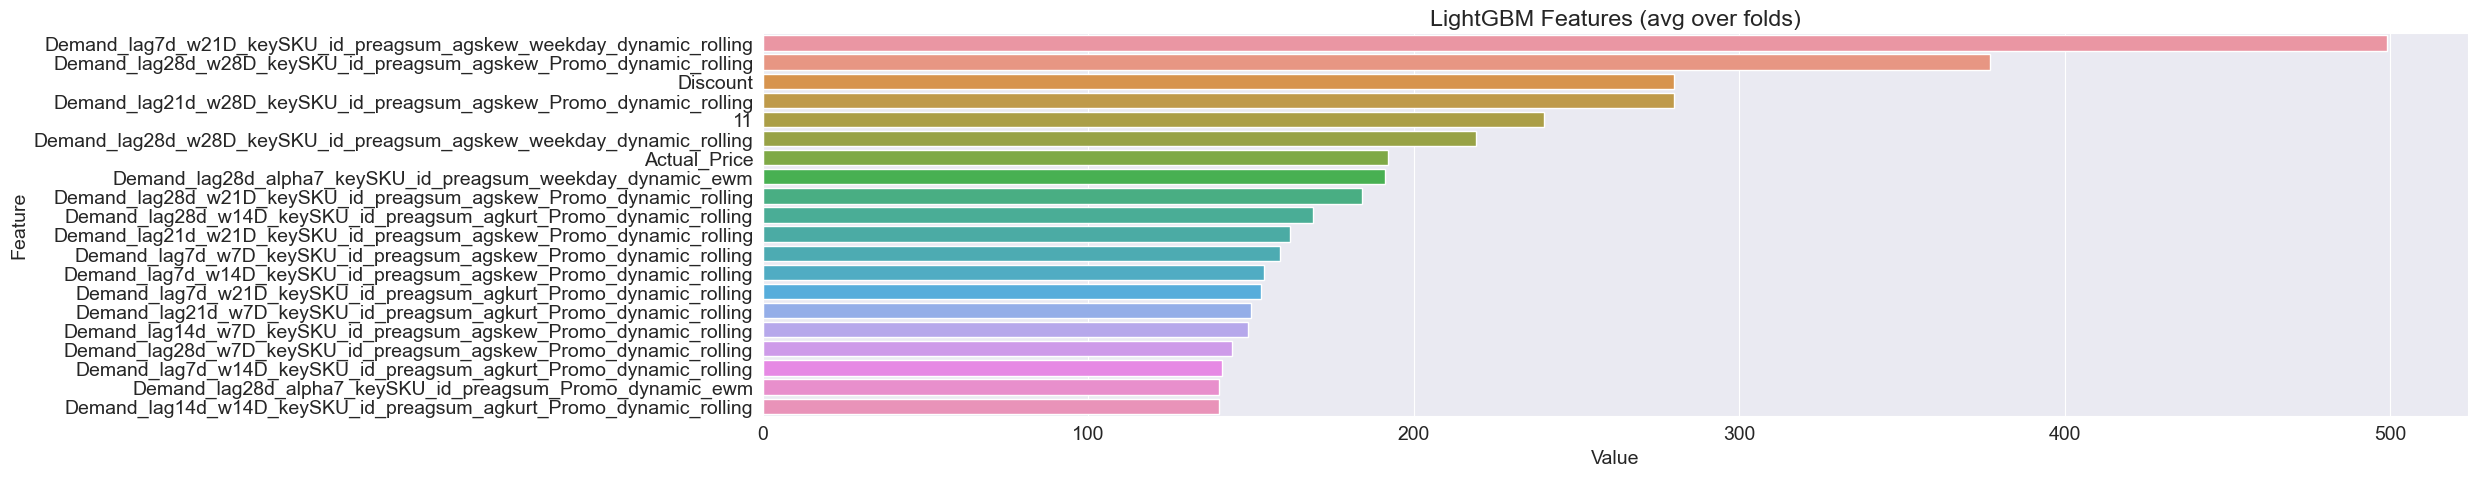

In [ ]:
plot_feature_importance(lgbms['1_1'], train_sets['1_1'][train_sets['1_1'].columns[3:]], num = 20)

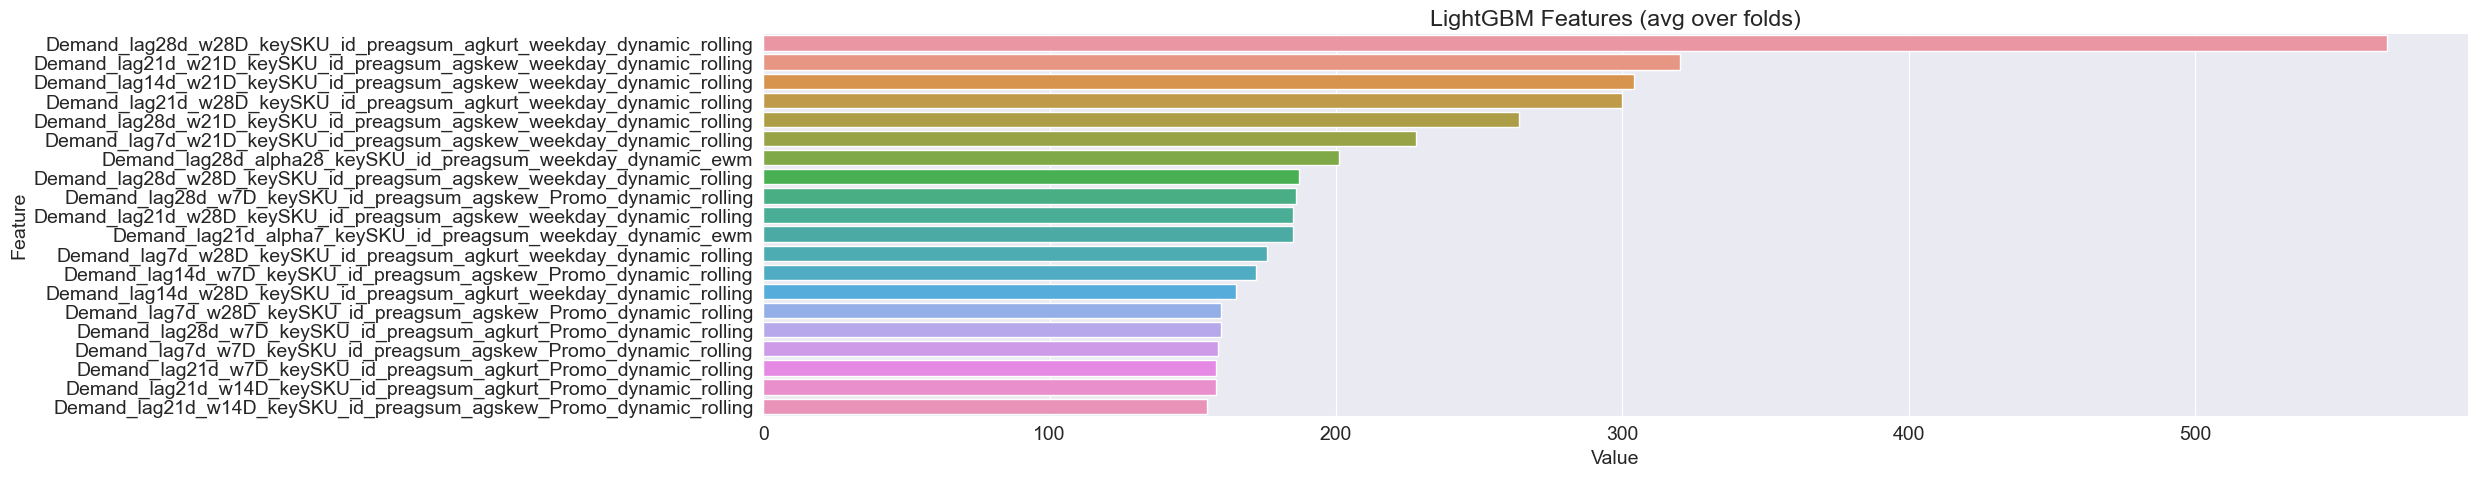

In [ ]:
plot_feature_importance(lgbms['1_2'], train_sets['1_2'][train_sets['1_2'].columns[3:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [ ]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [ ]:
# Train sets
train_sets_II = {}

for key, value in train_sets.items():
    X_train = value.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1)
    y_train = value.loc[:test_start_dt].Demand
    train_sets_II[key] = (X_train, y_train)

In [ ]:
# test sets
test_sets = {}

for key, value in train_sets.items():
    test_sets[key] = value.loc[test_start_dt:].drop(['SKU_id','Store_id','Demand'], axis=1)

In [ ]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

def wappe(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100
    return res

In [ ]:
# run TS CV for lgbms

for key, value in lgbms.items():
    try:
        (x_train, y_train) = train_sets_II[key]
    
        performTimeSeriesCV(x_train, y_train, 17, value, wappe, kwargs)
    except Exception:
        print("CV failed for " + key)

Size train set: (508, 112)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train and test: (58, 112)
[2]	valid_0's l1: 163.995
[4]	valid_0's l1: 163.995
[6]	valid_0's l1: 163.995
[8]	valid_0's l1: 163.995
[10]	valid_0's l1: 163.995

Splitting the first 3 chunks at 2/3
Size of train and test: (87, 112)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 184.073
[4]	valid_0's l1: 177.977
[6]	valid_0's l1: 178.366
[8]	valid_0's l1: 177.16
[10]	valid_0's l1: 178.312
[12]	valid_0's l1: 177.658
[14]	valid_0's l1: 177.498

Splitting the first 4 chunks at 3/4
Size of train and test: (116, 112)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 198.642
[4]	valid_0's l1: 188.369
[6]	valid_0's l1: 182.969
[8]	valid_0's l1: 189.274
[10]	valid_0's l1: 184.277
[12]	valid_0's l1: 182.301
[14]	valid_0's l

In [ ]:
transformed = ohe.fit_transform(data_lagged_features[['Store_id']])
data_lagged_features[ohe.categories_[0]] = transformed.toarray()
data_lagged_features_no_store_id = data_lagged_features.drop('Store_id', axis=1)

sku1_train = data_lagged_features_no_store_id[data_lagged_features_no_store_id['SKU_id'] == 1]
sku2_train = data_lagged_features_no_store_id[data_lagged_features_no_store_id['SKU_id'] == 2]

lgbm_sku1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

X_train1 = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:test_start_dt].Demand

lgbm_sku1.fit(X = X_train1, y = y_train1)

feature_imp = pd.DataFrame({'Value':lgbm_sku1.feature_importances_,'Feature':X_train1.columns})
feature_imp = feature_imp.sort_values(by="Value", ascending=False)[0:20]
X_train1 = X_train1[feature_imp['Feature']]

lgbm_sku2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')


X_train2 = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1)
y_train2 = sku2_train.loc[:test_start_dt].Demand

lgbm_sku2.fit(X = X_train2, y = y_train2)

feature_imp = pd.DataFrame({'Value':lgbm_sku2.feature_importances_,'Feature':X_train2.columns})
feature_imp = feature_imp.sort_values(by="Value", ascending=False)[0:20]
X_train2 = X_train2[feature_imp['Feature']]

# Test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test1 = X_test1[feature_imp['Feature']]
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test2 = X_test2[feature_imp['Feature']]

performTimeSeriesCV(X_train1, y_train1, 17, lgbm_sku1, wappe, kwargs)
performTimeSeriesCV(X_train2, y_train2, 17, lgbm_sku2, wappe, kwargs)

Size train set: (43733, 20)
Size of each fold: 2572

Splitting the first 2 chunks at 1/2
Size of train and test: (5144, 20)
[2]	valid_0's l1: 249.436
[4]	valid_0's l1: 241.687
[6]	valid_0's l1: 236.137
[8]	valid_0's l1: 236.35
[10]	valid_0's l1: 231.925
[12]	valid_0's l1: 229.287
[14]	valid_0's l1: 227.656
[16]	valid_0's l1: 226
[18]	valid_0's l1: 225.267
[20]	valid_0's l1: 223.4
[22]	valid_0's l1: 223.588
[24]	valid_0's l1: 222.366
[26]	valid_0's l1: 221.592
[28]	valid_0's l1: 220.963
[30]	valid_0's l1: 220.661
[32]	valid_0's l1: 220.284
[34]	valid_0's l1: 220.156
[36]	valid_0's l1: 219.981
[38]	valid_0's l1: 220.014
[40]	valid_0's l1: 219.899
[42]	valid_0's l1: 219.752
[44]	valid_0's l1: 219.795
[46]	valid_0's l1: 219.641
[48]	valid_0's l1: 219.518
[50]	valid_0's l1: 219.498
[52]	valid_0's l1: 219.497
[54]	valid_0's l1: 219.499
[56]	valid_0's l1: 219.501
[58]	valid_0's l1: 219.399
[60]	valid_0's l1: 219.41
[62]	valid_0's l1: 219.371
[64]	valid_0's l1: 219.32
[66]	valid_0's l1: 219.29

182.95205352109917

In [ ]:
parameters = {
    'metric' : ['mae'],
    'n_estimators': [ 100, 200, 500 ],
    'learning_rate':[ 0.1, 0.05, 0.005 ],
    'feature_fraction': [ 0.6, 0.8, 0.9],
    'num_leaves':[ 20, 40, 60 ]
}

gsearch_lgbm_sku1 = GridSearchCV(lgbm_sku1, param_grid = parameters, n_jobs = 6, verbose = 10)
gsearch_lgbm_sku1.fit(X_train1, y_train1)

gsearch_lgbm_sku2 = GridSearchCV(lgbm_sku2, param_grid = parameters, n_jobs = 6, verbose = 10)
gsearch_lgbm_sku2.fit(X_train2, y_train2)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(estimator=LGBMRegressor(feature_fraction=0.7, metric='mae',
                                     n_estimators=500, num_leaves=40,
                                     subsample=0.4),
             n_jobs=6,
             param_grid={'feature_fraction': [0.6, 0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.005], 'metric': ['mae'],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 40, 60]},
             verbose=10)

## Forecast Generation with ML

In [ ]:
# forecast

for key, value in test_sets.items():
    value['y_pred'] = lgbms[key].predict(value)

X_test1['y_pred'] = gsearch_lgbm_sku1.predict(X_test1)
X_test2['y_pred'] = gsearch_lgbm_sku2.predict(X_test2)

<AxesSubplot: xlabel='Date'>

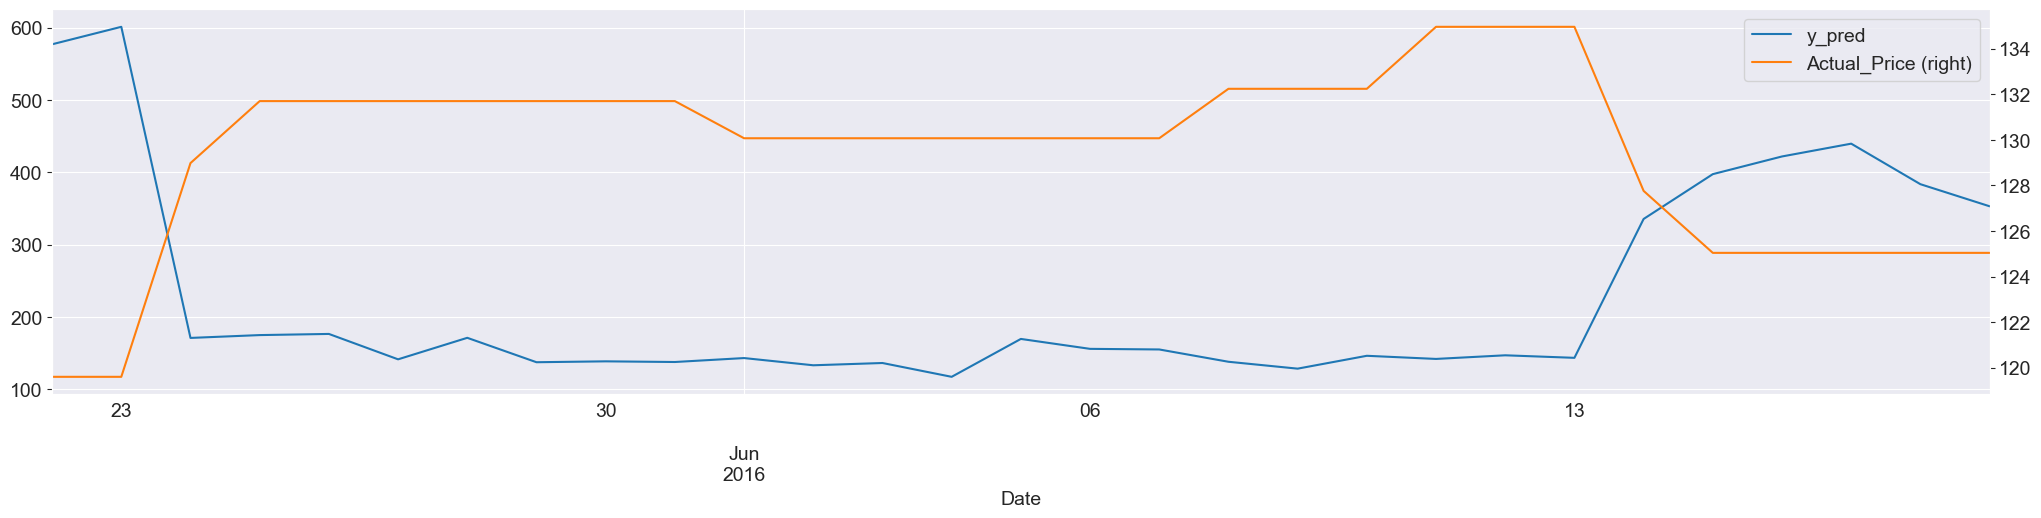

In [ ]:
X_test1 = test_sets['1_1']
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

<AxesSubplot: xlabel='Date'>

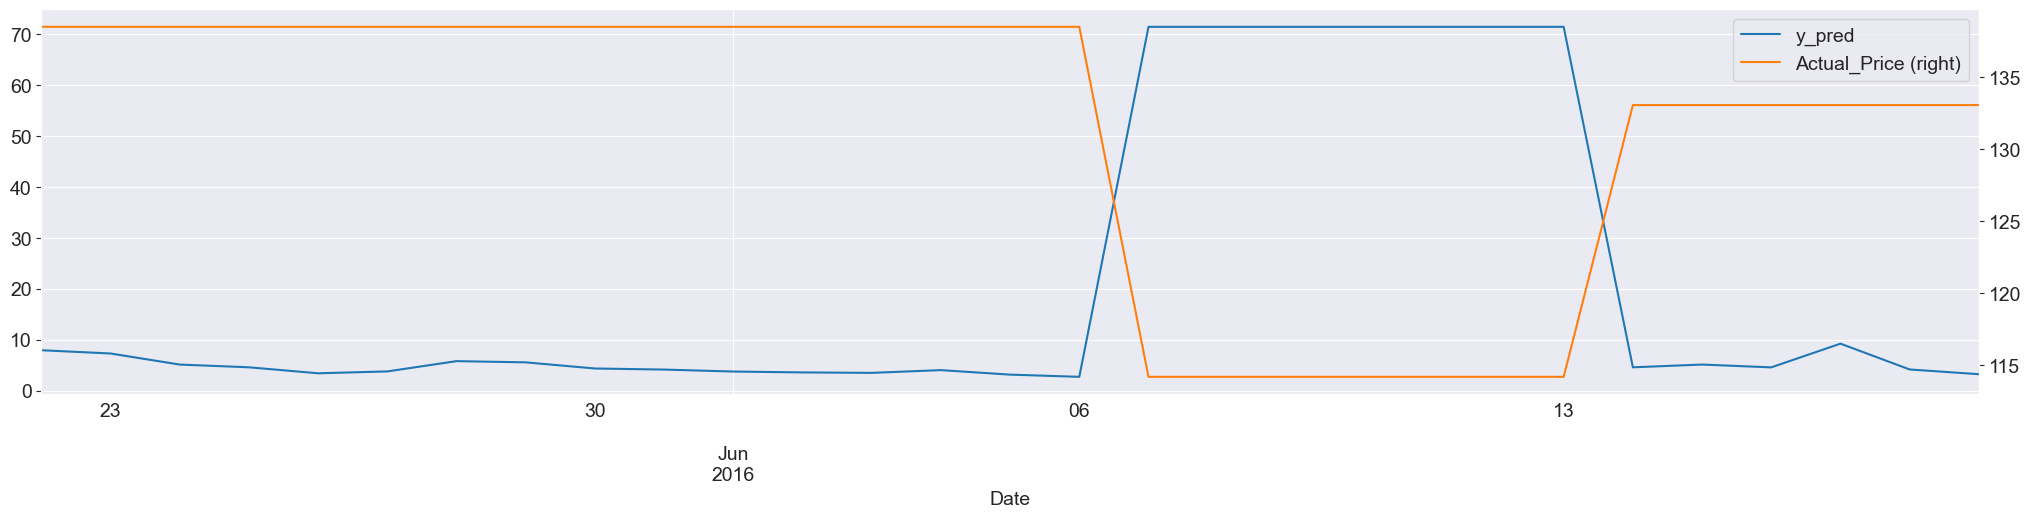

In [ ]:
X_test2 = test_sets['1_2']
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

**Note**: forecast highly depends on key drivers

In [ ]:
answer = pd.DataFrame()

for index, row in ts_retail_test.iterrows():
    key = '%i_%i' % (row['Store_id'], row['SKU_id'])
    
    if key not in test_sets.keys():
        value = 0
        
        if int(row['SKU_id']) == 1:
            value = X_test1.loc[index]['y_pred'] 
        else:
            value = X_test2.loc[index]['y_pred'] 
        
        answer = answer.append({'Demand': value }, ignore_index = True)
    else:
        x_test = test_sets[key]
        answer = answer.append({'Demand': x_test.loc[index]['y_pred'] }, ignore_index = True)
        
answer.to_csv('submission_sample.csv')

In [2836]:
answer.head()

Demand
0  567.192367
1  174.369649
2  171.682165
3  165.959953
4  139.678968

In [2518]:
# ts_retail_test.loc[pd.Date('2016-01-06')]

X_test2.head(100)

Promo  Actual_Price   Discount  weekday  is_weekend    1    2  \
Date                                                                        
2016-05-22    0.0        138.50   0.000000        6           1  0.0  0.0   
2016-05-23    0.0        138.50   0.000000        0           0  0.0  0.0   
2016-05-24    0.0        138.50   0.000000        1           0  0.0  0.0   
2016-05-25    0.0        138.50   0.000000        2           0  0.0  0.0   
2016-05-26    0.0        138.50   0.000000        3           0  0.0  0.0   
2016-05-27    0.0        138.50   0.000000        4           0  0.0  0.0   
2016-05-28    0.0        138.50   0.000000        5           1  0.0  0.0   
2016-05-29    0.0        138.50   0.000000        6           1  0.0  0.0   
2016-05-30    0.0        138.50   0.000000        0           0  0.0  0.0   
2016-05-31    0.0        138.50   0.000000        1           0  0.0  0.0   
2016-06-01    0.0        138.50   0.000000        2           0  0.0  0.0   
2016-06-02    0.0        138.50   0.000000        3           0  0.0  0.0   
2016-06-03    0.0        138.50   0.000000        4           0  0.0  0.0   
2016-06-04    0.0        138.50   0.000000        5           1  0.0  0.0   
2016-06-05    0.0        138.50   0.000000        6           1  0.0  0.0   
2016-06-06    0.0        138.50   0.000000        0           0  0.0  0.0   
2016-06-07    1.0        114.17  21.310327        1           0  0.0  0.0   
2016-06-08    1.0        114.17  21.310327        2           0  0.0  0.0   
2016-06-09    1.0        114.17  21.310327        3           0  0.0  0.0   
2016-06-10    1.0        114.17  21.310327        4           0  0.0  0.0   
2016-06-11    1.0        114.17  21.310327        5           1  0.0  0.0   
2016-06-12    1.0        114.17  21.310327        6           1  0.0  0.0   
2016-06-13    1.0        114.17  21.310327        0           0  0.0  0.0   
2016-06-14    0.0        133.06   0.000000        1           0  0.0  0.0   
2016-06-15    0.0        133.06   0.000000        2           0  0.0  0.0   
2016-06-16    0.0        133.06   0.000000        3           0  0.0  0.0   
2016-06-17    0.0        133.06   0.000000        4           0  0.0  0.0   
2016-06-18    0.0        133.06   0.000000        5           1  0.0  0.0   
2016-06-19    0.0        133.06   0.000000        6           1  0.0  0.0   

              3    4    5  ...  \
Date                       ...   
2016-05-22  0.0  0.0  1.0  ...   
2016-05-23  0.0  0.0  1.0  ...   
2016-05-24  0.0  0.0  1.0  ...   
2016-05-25  0.0  0.0  1.0  ...   
2016-05-26  0.0  0.0  1.0  ...   
2016-05-27  0.0  0.0  1.0  ...   
2016-05-28  0.0  0.0  1.0  ...   
2016-05-29  0.0  0.0  1.0  ...   
2016-05-30  0.0  0.0  1.0  ...   
2016-05-31  0.0  0.0  1.0  ...   
2016-06-01  0.0  0.0  0.0  ...   
2016-06-02  0.0  0.0  0.0  ...   
2016-06-03  0.0  0.0  0.0  ...   
2016-06-04  0.0  0.0  0.0  ...   
2016-06-05  0.0  0.0  0.0  ...   
2016-06-06  0.0  0.0  0.0  ...   
2016-06-07  0.0  0.0  0.0  ...   
2016-06-08  0.0  0.0  0.0  ...   
2016-06-09  0.0  0.0  0.0  ...   
2016-06-10  0.0  0.0  0.0  ...   
2016-06-11  0.0  0.0  0.0  ...   
2016-06-12  0.0  0.0  0.0  ...   
2016-06-13  0.0  0.0  0.0  ...   
2016-06-14  0.0  0.0  0.0  ...   
2016-06-15  0.0  0.0  0.0  ...   
2016-06-16  0.0  0.0  0.0  ...   
2016-06-17  0.0  0.0  0.0  ...   
2016-06-18  0.0  0.0  0.0  ...   
2016-06-19  0.0  0.0  0.0  ...   

            Demand_lag28d_w14D_keySKU_id_preagcount_agskew_weekday_dynamic_rolling  \
Date                                                                                 
2016-05-22                                                NaN                        
2016-05-23                                                NaN                        
2016-05-24                                                NaN                        
2016-05-25                                                NaN                        
2016-05-26                                           

In [2519]:
X_test2.loc[pd.Timestamp('2016-06-01')]

Promo                                                                         0.000000
Actual_Price                                                                138.500000
Discount                                                                      0.000000
weekday                                                                       2.000000
is_weekend                                                                    0.000000
                                                                               ...    
Demand_lag28d_w28D_keySKU_id_preagcount_agmean_weekday_dynamic_rolling       99.500000
Demand_lag28d_w28D_keySKU_id_preagcount_agmedian_weekday_dynamic_rolling     98.500000
Demand_lag28d_w28D_keySKU_id_preagcount_agpctl10_weekday_dynamic_rolling           NaN
Demand_lag28d_w28D_keySKU_id_preagcount_agskew_weekday_dynamic_rolling        1.779179
y_pred                                                                        3.879764
Name: 2016-06-01 00:00:00, Length: 325, dty

**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128